In [1]:
import json
import yaml
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
config = yaml.safe_load(open("/gscratch/balazinska/enhaoz/VOCAL-UDF/configs/config.yaml", "r"))

import re
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

######## gpt-4-1106-preview ########
task_0_new_udfs_mean_accuracy: 0.9870899999999999
task_0_new_udfs_mean_f1: 0.954133159367029
task_0_new_udfs_mean_precision: 0.950567769720821
task_0_new_udfs_mean_recall: 0.9669296789274516
task_0_new_udfs_prob_failures: 0.0

task_1_new_udfs_mean_accuracy: 0.8602220000000002
task_1_new_udfs_mean_f1: 0.4714687012059659
task_1_new_udfs_mean_precision: 0.4336805779793669
task_1_new_udfs_mean_recall: 0.6117796884575682
task_1_new_udfs_prob_failures: 0.22

task_2_new_udfs_mean_accuracy: 0.787276
task_2_new_udfs_mean_f1: 0.15206893396740537
task_2_new_udfs_mean_precision: 0.15563571009364002
task_2_new_udfs_mean_recall: 0.2703296301095656
task_2_new_udfs_prob_failures: 0.34

task_3_new_udfs_mean_accuracy: 0.8434540000000001
task_3_new_udfs_mean_f1: 0.018975824052293633
task_3_new_udfs_mean_precision: 0.016141015370318437
task_3_new_udfs_mean_recall: 0.029807233009007873
task_3_new_udfs_prob_failures: 0.74

######## gpt-3.5-turbo-1106 ########
task_0_new_

/gscratch/balazinska/enhaoz/jupyter/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gscratch/balazinska/enhaoz/jupyter/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


failed task: qid-2_run-1
failed task: qid-9_run-1
task_3_new_udfs_mean_accuracy: -1.0
task_3_new_udfs_mean_f1: 0.771207714041955
task_3_new_udfs_mean_precision: -1.0
task_3_new_udfs_mean_recall: -1.0
task_3_new_udfs_prob_failures: 0.06666666666666667



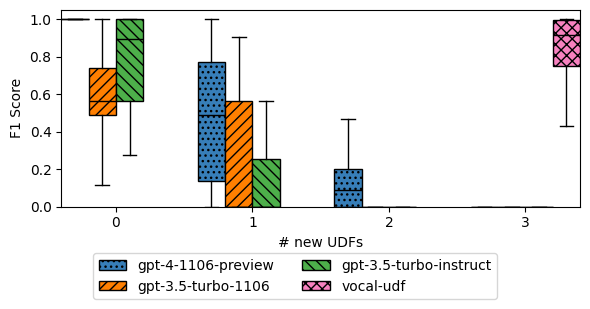

In [3]:
# Define LLM models, tasks, number of new UDFs, and hatch patterns
llm_models = ['gpt-4-1106-preview', 'gpt-3.5-turbo-1106', 'gpt-3.5-turbo-instruct', 'vocal-udf']
tasks = [f"{i}_new_udfs" for i in range(4)]
num_new_udfs = [0, 1, 2, 3]
# num_new_udfs = [0, 1]
hatch_patterns = ['...', '///', '\\\\\\', 'xxx']
handles_f1 = []

# Create a figure and axis for the boxplot
fig, ax = plt.subplots(1, 1, figsize=(6, 2.7))  # Adjust the figsize as needed

# Iterate through LLM models
for i, llm_model in enumerate(llm_models):
    print(f"######## {llm_model} ########")
    f1_data = []

    # Iterate through tasks
    for task in tasks:
        accuracy_list = []
        f1_list = []
        precision_list = []
        recall_list = []
        failed_list = []

        # Iterate through runs and questions
        if llm_model in ['vocal-udf']:
            for run_id in range(3):
                for question_id in range(10):
                    if '3' in task:
                        try:
                            with open(os.path.join(config['log_dir'], "udf_generation", "clevrer", f"qid-{question_id}_run-{run_id}-budget-10_ninterp-20.log"), "r") as f:
                                last_line = f.readlines()[-1]
                            f1_score_pattern = r"F1 score: ([0-9.]+)"
                            match = re.search(f1_score_pattern, last_line)
                            f1_score = 0
                            if match:
                                f1_score = float(match.group(1))
                                failed_list.append(0)
                            else:
                                print(f"failed task: qid-{question_id}_run-{run_id}")
                                failed_list.append(1)
                            f1_list.append(f1_score)
                            accuracy_list.append(-1)
                            precision_list.append(-1)
                            recall_list.append(-1)
                        except Exception as e:
                            print(e)
                            continue

        else:
            for run_id in range(5):
                for question_id in range(10):
                    try:
                        with open(os.path.join(config['output_dir'], "clevrer", llm_model, f"task_{task}_labels_run_{run_id}_question_{question_id}.json"), "r") as f:
                            data = json.load(f)
                        accuracy_list.append(data["accuracy"])
                        f1_list.append(data["f1"])
                        precision_list.append(data["precision"])
                        recall_list.append(data["recall"])
                        failed_list.append(data["failed"])
                        if '0' in task and data["failed"] > 0:
                            print(run_id, question_id)
                    except Exception as e:
                        print(e)
                        continue


        f1_data.append(f1_list)
        print(f"task_{task}_mean_accuracy: {np.mean(accuracy_list)}")
        print(f"task_{task}_mean_f1: {np.mean(f1_list)}")
        print(f"task_{task}_mean_precision: {np.mean(precision_list)}")
        print(f"task_{task}_mean_recall: {np.mean(recall_list)}")
        print(f"task_{task}_prob_failures: {np.mean(failed_list)}")
        print()

    # Create a grouped boxplot for F1 scores
    bp_f1 = ax.boxplot(f1_data,
                       positions=np.array(range(len(f1_data))) * (len(llm_models) + 1) + i,
                       sym='.',
                       widths=1,
                       showfliers=False,
                       patch_artist=True,
                       boxprops=dict(facecolor=CB_color_cycle[i], hatch=hatch_patterns[i]),
                       medianprops=dict(color='black'))
    handles_f1.append(bp_f1["boxes"][0])

# Customize the plot labels and legend
ax.set(ylabel="F1 Score")
ax.set(xlabel="# new UDFs")
ax.set_ylim(bottom=0, top=1.05)
ax.set_xticks(np.arange(len(llm_models) / 2 - 0.5, len(num_new_udfs) * len(llm_models) + len(llm_models) / 2 + 0.5, len(llm_models) + 1))
ax.set_xticklabels(num_new_udfs)
fig.legend(handles_f1, llm_models, prop={"size": 10}, loc='upper center', bbox_to_anchor=(0.5, 0.07),
           fancybox=True, shadow=False, ncol=2)
plt.subplots_adjust(bottom=0.15)
fig.tight_layout()
plt.show()